## Variables à ajouter issues des recherches biblio

Variable(s): 

- Population des pays représentés 
- Variable indiquant si le pays est communiste ou pas 
- Variable indiquant si le pays est stable ou pas 
- Variable indiquant si le pays est émergeant ou pas ( otherwise pauvre , riche à peaufiner par la suite) 
- Variable indiquant si le pays a la culture du sport ou pas. 
- Variable indiquant le PIB par habitant 
- Variable indiquant les financements alloués aux sports (olympiques ou pas)


Il faut créer le train et le test avec des données 2024 , il faut les construire , il faut aussi savoir traiter le fait que cette fois ci la Russie ne sera pas disponible .
Faire indice : pays perturbé 1 avec Russie par exemple ou bien on enlève la Russie  (contexte géopolitique simple, on tah les années où j'ai eu un pb )

But c'est de prédire le nombre de médailles pour chaque pays , indicateur simple 

In [114]:
# !pip install ydata_profiling

In [114] used 0.0 MiB RAM in 0.10s (system mean cpu 3%, single max cpu 13%), peaked 0.0 MiB above final usage, current RAM usage now 769.6 MiB


In [115]:
import pandas as pd
import numpy as np
import ipython_memory_usage.ipython_memory_usage as imu
from describe_csv import *  # charge le fichier describe_csv.py par chunk de 10 000 (10**4)
from ydata_profiling import ProfileReport
import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy as sp
import scipy.stats
from pivottablejs import pivot_ui
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

imu.start_watching_memory()



In [115] used 0.0 MiB RAM in 0.11s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 769.6 MiB


# TODO -- Introduction  (Business Understanding) 

## TODO Détermination objectifs métier , analytique du projet 

## TODO Identifier les contraintes , limites et risque du projet

# 2. Data understanding (compréhension des données)


## 2.1.  Chargement des données

### Chargement des différentes bases de données + étude du chargement en mémoire

In [116]:
df = pd.read_csv("data/athlete_events.csv")
region_df = pd.read_csv("data/noc_regions.csv")
dictionary = pd.read_csv("data/dictionary.csv")

In [116] used 34.8 MiB RAM in 0.64s (system mean cpu 8%, single max cpu 75%), peaked 26.2 MiB above final usage, current RAM usage now 804.4 MiB


In [117]:
# méthode pour calculer la taille réelle occupée par le dataframe : les index occupent aussi de la place en mémoire
df.memory_usage(index=True).sum()

32534052

In [117] used 0.0 MiB RAM in 0.11s (system mean cpu 3%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 804.5 MiB


32534052 octets = 32,53 MB =  32534,052 KB.

## 2.2 Décrire les données

### Charger les données avec describe_csv et indiquer les types optimaux pour chaque colonne. 

In [118]:
describe_csv("data/athlete_events.csv", delimiter=',')

0 M rows approx.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
---------------------------------------------------
data/athlete_events.csv
---------------------------------------------------
       Col     type    min     max  nulls optimal type
0       ID    int64      1  135571      0        int32
1     Name   object      -       -      -       object
2      Sex   object      -       -      -       object
3      Age  float64   10.0    97.0   9474         int8
4   Height  float64  127.0   226.0  60171        int16
5   Weight  float64   25.0   214.0  62875        int16
6     Team   object      -       -      -       object
7      NOC   object      -       -      -       object
8    Games   object      -       -      -       object
9     Year    int64   1896    2016      0        int16
10  Season   object      -       -      -       object
11    City   object      -       -      -       object
12   Sport   object      -       -      -       object
13   Even

In [119]:
describe_csv("data/noc_regions.csv", delimiter=',')
describe_csv("data/dictionary.csv", delimiter=',')

0 M rows approx.
1 
---------------------------------------------------
data/noc_regions.csv
---------------------------------------------------
      Col    type min max nulls optimal type
0     NOC  object   -   -     -       object
1  region  object   -   -     -       object
2   notes  object   -   -     -       object

 0  rows
0 M rows approx.
1 
---------------------------------------------------
data/dictionary.csv
---------------------------------------------------
              Col     type         min            max nulls optimal type
0         Country   object           -              -     -       object
1            Code   object           -              -     -       object
2      Population  float64     10222.0   1371220000.0     5        int32
3  GDP per Capita  float64  277.068309  101449.968168    25      float32

 201  rows
In [119] used 0.0 MiB RAM in 0.13s (system mean cpu 12%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 811.4 MiB

### Nombre de données manquantes par feature

In [120]:
df.isna().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

In [120] used 0.5 MiB RAM in 0.19s (system mean cpu 6%, single max cpu 100%), peaked 2.6 MiB above final usage, current RAM usage now 812.0 MiB


## EDA

### Terget Medals : Nous allons construire des représentations graphiques nous permettant d'observer les Medals en fonction des autres variables.On effectue des transformations sur les données pour les besoins de cette analyse exploratoire (pas forcément les mêmes transformations que celles nécessaires lors de l'étape de Feature engineering).

In [121]:
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [121] used 0.0 MiB RAM in 0.12s (system mean cpu 3%, single max cpu 80%), peaked 0.0 MiB above final usage, current RAM usage now 812.0 MiB


In [122]:
df['NOC'] = df['NOC'].replace(['Soviet Union', 'URS'], 'RUS')

df['Team'] = df['Team'].replace(['Soviet Union', 'URS'], 'Russia')
df['Team'] = df['Team'].replace(['East Germany'], 'Germany')

In [122] used 4.1 MiB RAM in 0.18s (system mean cpu 3%, single max cpu 100%), peaked 4.1 MiB above final usage, current RAM usage now 816.1 MiB


In [123]:
df.drop_duplicates(inplace=True)


In [123] used 28.8 MiB RAM in 0.43s (system mean cpu 5%, single max cpu 100%), peaked 23.4 MiB above final usage, current RAM usage now 844.9 MiB


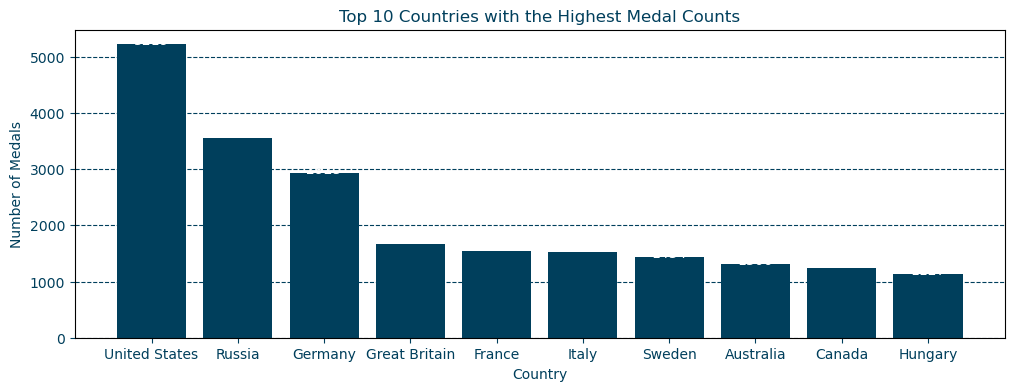

In [124] used 1.5 MiB RAM in 0.30s (system mean cpu 2%, single max cpu 100%), peaked 1.8 MiB above final usage, current RAM usage now 846.5 MiB


In [124]:
top_10_countries = df.groupby('Team')['Medal'].count().nlargest(10)

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(top_10_countries.index, top_10_countries.values, color='#003f5c')
ax.set_title('Top 10 Countries with the Highest Medal Counts', color='#003f5c')
ax.set_xlabel('Country', color='#003f5c')
ax.set_ylabel('Number of Medals', color='#003f5c')
ax.tick_params(axis='both', colors='#003f5c')
ax.grid(axis='y', linestyle='--', color='#003f5c')

for i, country in enumerate(top_10_countries.index):
    ax.text(i, top_10_countries[country] + 0.5, str(top_10_countries[country]), color='white', ha='center')

plt.show()


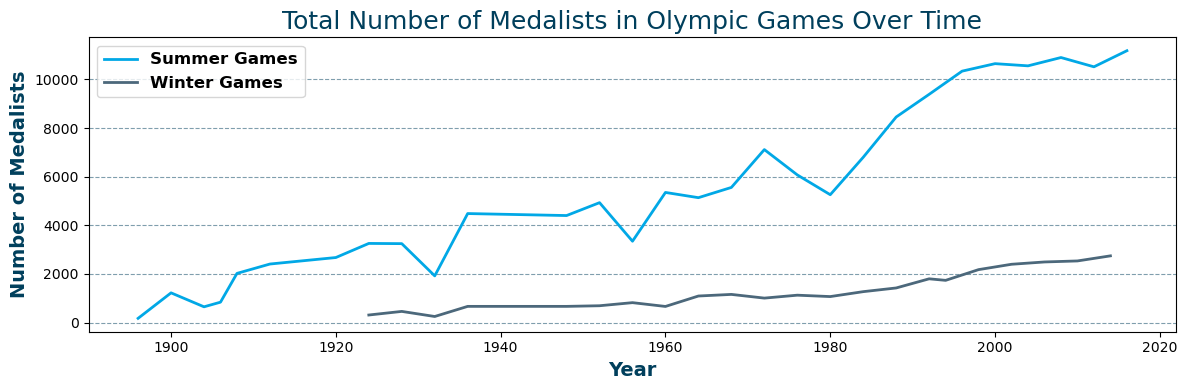

In [125] used 2.2 MiB RAM in 0.41s (system mean cpu 3%, single max cpu 100%), peaked 36.5 MiB above final usage, current RAM usage now 848.7 MiB


In [125]:
# Group the data by year and count the number of unique medalists for summer games
summer_medalists = df[df['Season'] == 'Summer'].groupby('Year')['ID'].nunique()

# Group the data by year and count the number of unique medalists for winter games
winter_medalists = df[df['Season'] == 'Winter'].groupby('Year')['ID'].nunique()

# Plot the data using a line plot
plt.figure(figsize=(12, 4))
summer_medalists.plot(label='Summer Games', color='#01a8e6', linewidth=2)
winter_medalists.plot(label='Winter Games', color='#4c687b', linewidth=2)
plt.title('Total Number of Medalists in Olympic Games Over Time', fontsize=18, color='#003f5c')
plt.xlabel('Year', fontsize=14, fontweight='bold', color='#003f5c')
plt.ylabel('Number of Medalists', fontsize=14, fontweight='bold', color='#003f5c')
plt.legend(prop={'size': 12, 'weight': 'bold'}, loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5, color='#003f5c')
plt.tight_layout()
plt.show()


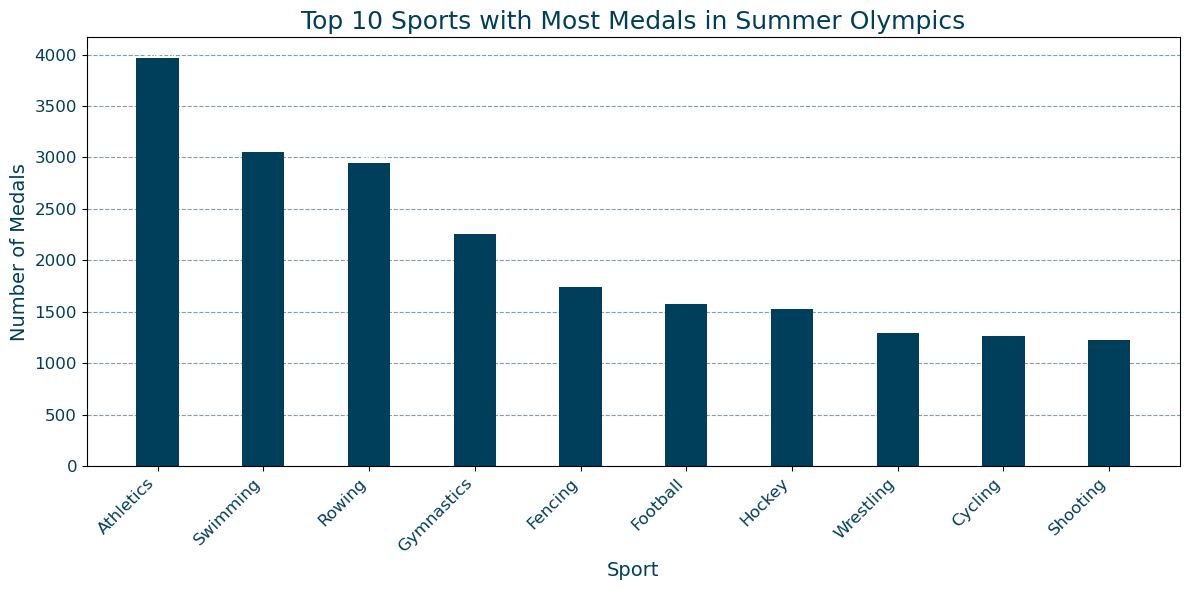

In [126] used 3.3 MiB RAM in 0.32s (system mean cpu 1%, single max cpu 100%), peaked 5.4 MiB above final usage, current RAM usage now 852.0 MiB


In [126]:
# Créer un graphique à barres pour visualiser les données
plt.figure(figsize=(12, 6))
bar_width = 0.4  # Ajoutez cette ligne pour définir la largeur des barres
bars = plt.bar(top_10_sports.index, top_10_sports['Medal Count'], width=bar_width, color='#003f5c')

# Ajouter le nombre de médailles remportées dans chaque barre
for i, bar in enumerate(bars):
    plt.text(i, bar.get_height() + 0.5, str(top_10_sports.loc[top_10_sports.index[i], 'Medal Count']), ha='center', color='white')

plt.title('Top 10 Sports with Most Medals in Summer Olympics', fontsize=18, color='#003f5c')
plt.xlabel('Sport', fontsize=14, color='#003f5c')
plt.ylabel('Number of Medals', fontsize=14, color='#003f5c')
plt.xticks(rotation=45, ha='right', fontsize=12, color='#003f5c')
plt.yticks(fontsize=12, color='#003f5c')
plt.grid(axis='y', linestyle='--', alpha=0.5, color='#003f5c')
plt.tight_layout()
plt.show()


In [127]:
!pip install tabulate

import tabulate

# Group the data by athlete name and count the number of medals
top_10_athletes = df.groupby(['Name', 'Sport'])['Medal'].count().sort_values(ascending=False).head(10)

# Reset the index to create columns for Name and Sport
top_10_athletes = top_10_athletes.reset_index()

# Rename the columns
top_10_athletes.columns = ['Athlete', 'Sport', 'Medal Count']

# Print the table using tabulate
print(tabulate.tabulate(top_10_athletes, headers='keys', tablefmt='grid', numalign='right'))


+----+-------------------------------------------------+------------+---------------+
|    | Athlete                                         | Sport      |   Medal Count |
+====+=================================================+============+===============+
|  0 | Michael Fred Phelps, II                         | Swimming   |            28 |
+----+-------------------------------------------------+------------+---------------+
|  1 | Larysa Semenivna Latynina (Diriy-)              | Gymnastics |            18 |
+----+-------------------------------------------------+------------+---------------+
|  2 | Nikolay Yefimovich Andrianov                    | Gymnastics |            15 |
+----+-------------------------------------------------+------------+---------------+
|  3 | Ole Einar Bjrndalen                             | Biathlon   |            13 |
+----+-------------------------------------------------+------------+---------------+
|  4 | Borys Anfiyanovych Shakhlin                    

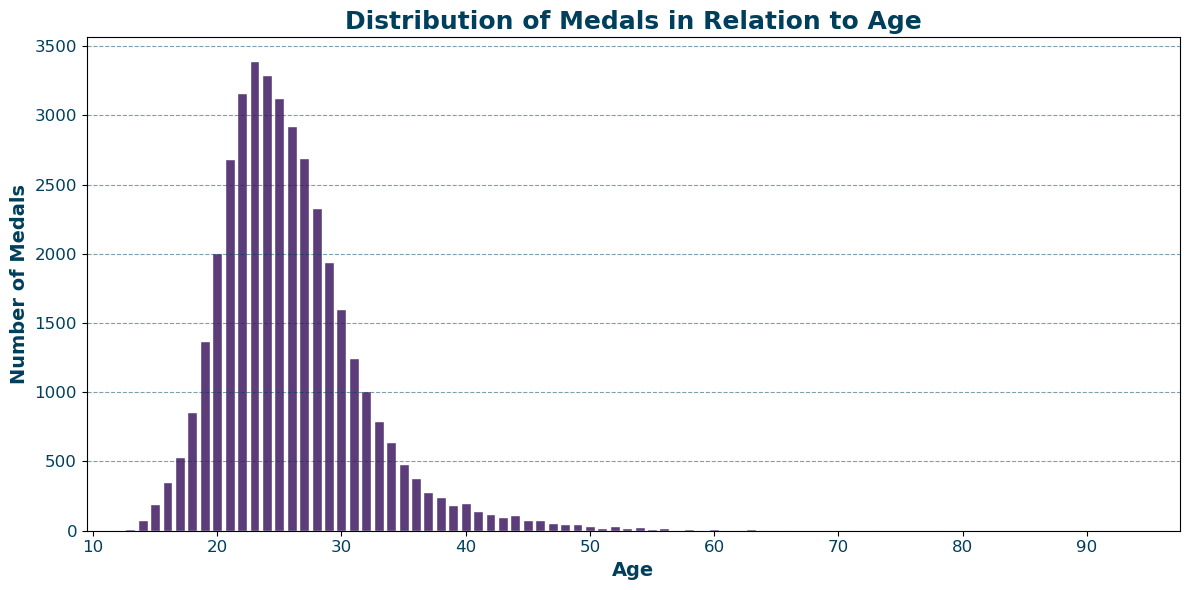

In [128] used 3.7 MiB RAM in 0.40s (system mean cpu 1%, single max cpu 100%), peaked 2.7 MiB above final usage, current RAM usage now 857.3 MiB


In [128]:
# Calculate the minimum and maximum age
min_age = df['Age'].min()
max_age = df['Age'].max()

# Group the data by age and count the number of medals for each age group
medals_by_age = df.groupby('Age')['Medal'].count()

# Filter the data between min and max age
filtered_medals_by_age = medals_by_age.loc[min_age:max_age]

# Plot the distribution of medals in relation to age
plt.figure(figsize=(12, 6))
plt.title('Distribution of Medals in Relation to Age', fontsize=18, fontweight='bold', color='#003f5c')
plt.xlabel('Age', fontsize=14, fontweight='bold', color='#003f5c')
plt.ylabel('Number of Medals', fontsize=14, fontweight='bold', color='#003f5c')
plt.bar(filtered_medals_by_age.index, filtered_medals_by_age.values, color='#5c3d7a', edgecolor='white')
plt.xticks(fontsize=12, color='#003f5c')
plt.yticks(fontsize=12, color='#003f5c')
plt.grid(axis='y', linestyle='--', alpha=0.5, color='#003f5c')
plt.xlim(min_age - 0.5, max_age + 0.5)
plt.tight_layout()
plt.show()


## Fusion des bases + Nettoyage

### Merge avec noc_regions 


In [129]:
df = pd.read_csv("data/athlete_events.csv")
region_df = pd.read_csv("data/noc_regions.csv")
print(df.shape)

(271116, 15)
In [129] used 0.1 MiB RAM in 0.65s (system mean cpu 2%, single max cpu 100%), peaked 58.8 MiB above final usage, current RAM usage now 857.4 MiB


#### Normalisation de pays en-tête de classement (Russie, Allemagne)

In [130]:
# RUSSIA
df['NOC'] = df['NOC'].replace(['Soviet Union', 'URS'], 'RUS')

# GERMANY
df['Team'] = df['Team'].replace(['Soviet Union', 'URS'], 'Russia')
df['Team'] = df['Team'].replace(['East Germany'], 'Germany')

In [130] used 4.9 MiB RAM in 0.19s (system mean cpu 8%, single max cpu 88%), peaked 0.0 MiB above final usage, current RAM usage now 862.3 MiB


In [136]:
# Summer seulement !!!

df = df[df['Season'] == "Summer"]
print(df.shape)

(222552, 17)
In [136] used 28.9 MiB RAM in 0.13s (system mean cpu 3%, single max cpu 15%), peaked 0.0 MiB above final usage, current RAM usage now 941.4 MiB


### Merge avec  region_df 


In [137]:
df = df.merge(region_df[['NOC', 'region']], how='left', on='NOC')
print(df.shape)

(222552, 18)
In [137] used 1.7 MiB RAM in 0.15s (system mean cpu 3%, single max cpu 18%), peaked 0.0 MiB above final usage, current RAM usage now 943.1 MiB


### Merge avec dictionary.csv 


In [138]:
df = df.merge(dictionary[['Code', 'GDP per Capita']], how='left', left_on='NOC', right_on='Code')
df.drop('Code', axis=1, inplace=True)
print(df.shape)

(222552, 19)
In [138] used 1.7 MiB RAM in 0.19s (system mean cpu 3%, single max cpu 20%), peaked 0.0 MiB above final usage, current RAM usage now 944.8 MiB


In [134]:
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,GDP per Capita
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,8027.683810
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,8027.683810
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark,51989.293471
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,51989.293471
4,8,"Cornelia ""Cor"" Aalten (-Strannood)",F,18.0,168.0,NaN,Netherlands,NED,1932 Summer,1932,Summer,Los Angeles,Athletics,Athletics Women's 100 metres,NaN,Netherlands,44299.768085


In [134] used 0.0 MiB RAM in 0.11s (system mean cpu 4%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 883.8 MiB
